# # Import required libraries

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [68]:
pip install xgboost

# Load historical weather data
 Assuming we have a function to fetch historical data for different locations and variables

In [69]:
# Map variables to dataset columns
COLUMN_MAPPING = {
    "temperature": "Temperature (C)",
    "humidity": "Humidity",
    "wind_speed": "Wind Speed (km/h)",
    "precipitation": "Precip Type"
}

In [70]:
def getHistData(location, variable):
    data = pd.read_csv('weatherHistory_1.csv')
    
    # Ensure the dataset contains the necessary columns
    if COLUMN_MAPPING[variable] not in data.columns:
        raise KeyError(f"Column '{COLUMN_MAPPING[variable]}' not found in the dataset.")
    
    # Set the target variable
    data['target'] = data[COLUMN_MAPPING[variable]]
    return data

In [71]:
# Call the function to read the data
# weather_data = getHistData('Gandhinagar', 'temperature')

# Display the first few rows of the data
# print(weather_data.head())


# Preprocessing function for the data

In [72]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(data):
    columns_to_drop = ['Formatted Date', 'Daily Summary', 'Summary']
    for col in columns_to_drop:
        if col in data.columns:
            data = data.drop(col, axis=1)
    
    # Convert categorical data to numeric
    if 'Precip Type' in data.columns:
        data = pd.get_dummies(data, columns=['Precip Type'], drop_first=True)
    
    # Scale the features
    scaler = StandardScaler()
    X = data.drop('target', axis=1)
    X_scaled = scaler.fit_transform(X)
    y = data['target']
    
    return X_scaled, y

# Boosted Decision Tree Training


In [73]:
def getBestParam(trainData):
    # Correct parameters for GradientBoostingRegressor
    return {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}

In [74]:
def TrainBDTree(trainData, params):
    from sklearn.ensemble import GradientBoostingRegressor
    X, y = trainData
    model = GradientBoostingRegressor(**params)
    model.fit(X, y)
    return model

# Gaussian Process Hyperparameter Tuning

In [75]:
def getBestHParam(variable, data):
    # Define the kernel with adjusted bounds
    kernel = C(10.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e3))
    
    # Preprocess data
    X, y = preprocess_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Gaussian Process Regressor without max_iter
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, optimizer="fmin_l_bfgs_b")
    gp.fit(X_train, y_train)
    
    # Evaluate the model
    score = gp.score(X_test, y_test)
    print(f"Gaussian Process Model for {variable} - R^2 score: {score}")

# Deep Belief Network (DBN) with Contrastive Divergence (CD)

In [76]:
class DBN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DBN, self).__init__()
        self.rbm = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        hidden = torch.sigmoid(self.rbm(x))
        output = torch.sigmoid(self.output_layer(hidden))
        return output

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

def ContrastiveDivergence(X_train, hidden_size=100, epochs=1000, lr=0.01):
    # Convert X_train to torch tensor directly
    X_train = torch.tensor(X_train).float()
    
    dbn_model = DBN(X_train.shape[1], hidden_size)
    optimizer = optim.Adam(dbn_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = dbn_model(X_train)
        loss = loss_fn(output, X_train)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return dbn_model


# Main Procedure for Weather Model Training

In [81]:
def TrainWeatherModels():
    location = 'Delhi'  # Modify as required
    variables = ['temperature', 'humidity', 'wind_speed']
    
    # Train models and store them
    BstDecTree = {}
    for var in variables:
        data = getHistData(location, var)
        trainData = preprocess_data(data)
        params = getBestParam(trainData)
        BstDecTree[(location, var)] = TrainBDTree(trainData, params)
    
    for var in variables:
        data = getHistData(location, var)
        getBestHParam(var, data)
    
    # Train DBN for temperature as an example
    all_data = getHistData(location, 'temperature')
    X_train, _ = preprocess_data(all_data)
    DBNmodel = ContrastiveDivergence(X_train)
    
    # Visualize Actual vs Predicted for each variable
    for var in variables:
        data = getHistData(location, var)
        X, y = preprocess_data(data)
        
        # Make predictions for the variable
        predictions = BstDecTree[(location, var)].predict(X)
        
        # Plot Actual vs Predicted
        plt.figure(figsize=(10, 6))
        plt.plot(y.values[:100], label=f'Actual {var.capitalize()}', color='blue')
        plt.plot(predictions[:100], label=f'Predicted {var.capitalize()}', color='red', linestyle='--')
        plt.title(f'Actual vs Predicted for {var.capitalize()}')
        plt.xlabel('Time')
        plt.ylabel(var.capitalize())
        plt.legend()
        plt.show()


C:\Users\amits\desktop\sample_project_1\env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian Process Model for temperature - R^2 score: 0.9979559680277413


C:\Users\amits\desktop\sample_project_1\env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\amits\desktop\sample_project_1\env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian Process Model for humidity - R^2 score: 0.9999999999863688
Gaussian Process Model for wind_speed - R^2 score: 0.9999997651838036
Epoch 0, Loss: 1.0971506834030151
Epoch 100, Loss: 0.5686843395233154
Epoch 200, Loss: 0.5523064732551575
Epoch 300, Loss: 0.5500460267066956
Epoch 400, Loss: 0.5491973757743835
Epoch 500, Loss: 0.5488250255584717
Epoch 600, Loss: 0.5486124157905579
Epoch 700, Loss: 0.5484690070152283
Epoch 800, Loss: 0.5483615398406982
Epoch 900, Loss: 0.5482743978500366


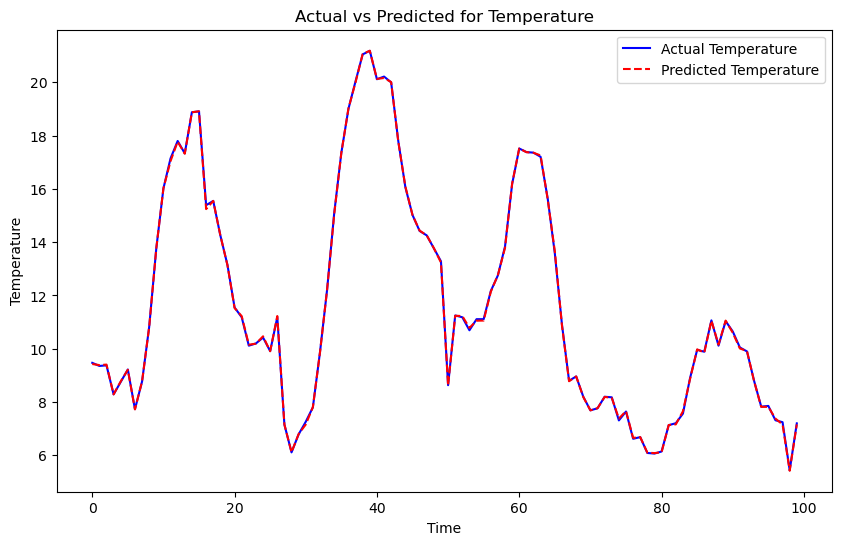

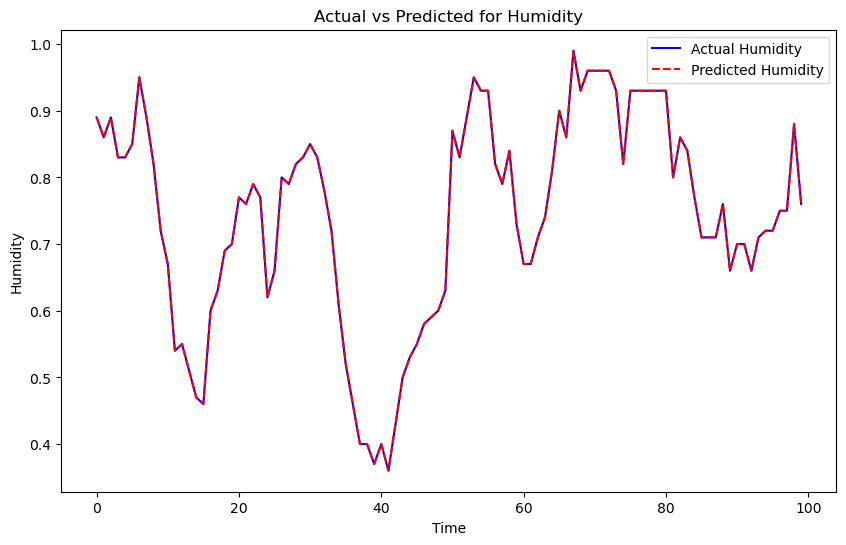

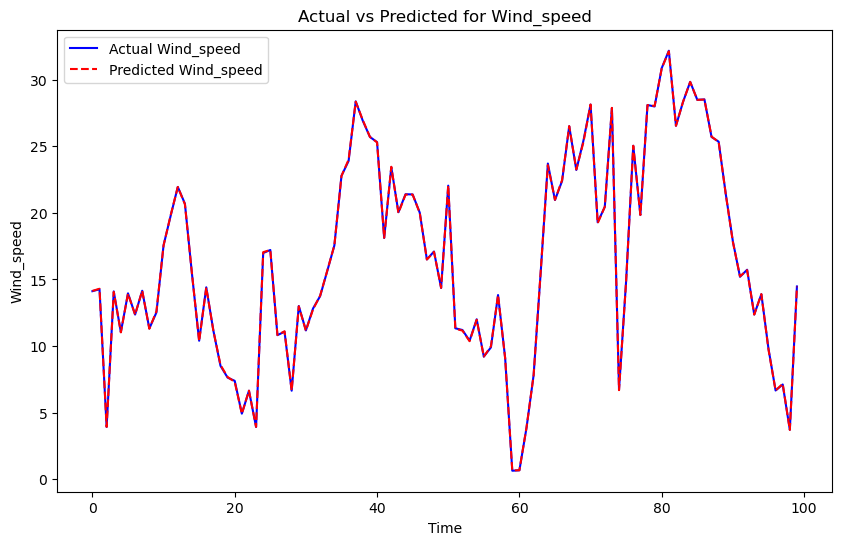

In [82]:
TrainWeatherModels()